In [21]:
# ==== Imports ====
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors
from matplotlib.ticker import MultipleLocator
from pathlib import Path
import mapclassify as mc
from matplotlib.ticker import FuncFormatter


import re
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter,MultipleLocator
import matplotlib.colors as mcolors


In [22]:
import sys
from pathlib import Path

repo_root = Path().resolve().parents[0]
sys.path.append(str(repo_root))

print("Added to sys.path:", repo_root)

# Your helpers
from utils.common_functions import save_or_show, load_df

Added to sys.path: D:\Joe\1\Stufffs\Research\Mapping Future Skills in UK Engineering Education


In [23]:
# ==== Paths (EDIT THESE) ====
SUBJECT_PATH  = r"../data/table-28-with-subject"
LOC_PATH      = r"../data/provider-location"
ITL1_GEOJSON  = r"../data/provider-location/itl1_2025_buc.geojson"

In [24]:
def publication_rc():
    plt.rcParams.update({
        "figure.figsize": (12, 6),
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        "lines.linewidth": 1.0,
        "axes.titleweight": "bold",
        "axes.labelweight": "bold",
        "legend.frameon": False,
        "font.family": "DejaVu Sans",
    })


In [25]:
# ==== Helpers ====
def norm_ukprn(series: pd.Series) -> pd.Series:
    """Normalize UKPRN so 10007783.0 -> '10007783' (string)."""
    return (pd.to_numeric(series, errors="coerce")
              .astype("Int64")
              .astype(str)
              .str.replace("<NA>", "", regex=False)
              .str.strip())

In [26]:
def keep_totals_slice(df: pd.DataFrame, filters: dict) -> pd.DataFrame:
    mask = pd.Series(True, index=df.index)
    for col, value in filters.items():
        mask &= df[col].eq(value)
    return df.loc[mask].copy()

In [27]:
def mode_region(s: pd.Series):
    m = s.mode()
    return sorted(m.astype(str))[0] if len(m) else None

In [28]:
# ==== Load data ====
publication_rc()

# Subject/enrolments table (HESA-like)
df_subj = load_df(SUBJECT_PATH, skip_rows=13)

# Provider locations with LAT/LON (Discover Uni/KIS-style export you prepared)
loc_df = load_df(LOC_PATH, skip_rows=0) 

# Normalize keys
df_subj["UKPRN"] = norm_ukprn(df_subj["UKPRN"])
loc_df["UKPRN"]  = norm_ukprn(loc_df["UKPRN"])

# Basic sanity for required columns
for c in ["UKPRN", "LATITUDE", "LONGITUDE"]:
    if c not in loc_df.columns:
        raise KeyError(f"locations file missing required column: {c}")

# Drop rows with missing coordinates
loc_df = loc_df.dropna(subset=["LONGITUDE", "LATITUDE"])

In [29]:
# ==== Define your analytical scope (EDIT if needed) ====
FILTERS = {
    "Subject area of degree": "10 Engineering and technology",
    "Activity": "Total",
    "Interim study": "Include significant interim study",
    "Level of qualification obtained": "All",
    "Mode of former study": "All",
    "Academic year": "2022/23",   # <- pick your year
}

enrol = keep_totals_slice(df_subj, FILTERS)[["UKPRN", "Number"]].copy()


In [30]:
# ==== Spatial join: assign each provider location to an ITL1 (12-region) polygon ====
# 1) Points
g_loc = gpd.GeoDataFrame(
    loc_df,
    geometry=gpd.points_from_xy(loc_df["LONGITUDE"], loc_df["LATITUDE"]),
    crs="EPSG:4326"
)

# 2) Regions polygons (ITL1)
regions = gpd.read_file(ITL1_GEOJSON).to_crs("EPSG:4326")
REG_NAME_COL = next(c for c in regions.columns if c.lower().endswith("nm") or "name" in c.lower())

# 3) Spatial join (use "intersects" to be robust for boundary points)
g_join = gpd.sjoin(
    g_loc,
    regions[[REG_NAME_COL, "geometry"]],
    how="left",
    predicate="intersects"
).rename(columns={REG_NAME_COL: "Provider region"})

In [31]:
# ==== Collapse to ONE region per provider (mode) ====
g_join["UKPRN"] = norm_ukprn(g_join["UKPRN"])
region_map = (g_join.dropna(subset=["Provider region"])
                    .groupby("UKPRN")["Provider region"]
                    .agg(mode_region))

In [32]:
# ==== Map region to enrol and aggregate ====
enrol2 = enrol.copy()
# Avoid duplicate columns if any
enrol2 = enrol2.loc[:, ~enrol2.columns.duplicated()].copy()
enrol2 = enrol2.drop(columns=["Provider region"], errors="ignore")
enrol2["UKPRN"] = norm_ukprn(enrol2["UKPRN"])
enrol2["Provider region"] = enrol2["UKPRN"].map(region_map)

# QA
matched_rows   = enrol2["Provider region"].notna().sum()
unmatched_rows = enrol2["Provider region"].isna().sum()
print(f"[QA] Enrol rows matched to a region: {matched_rows:,}  |  Unmatched: {unmatched_rows:,}")

if matched_rows == 0:
    raise RuntimeError("0 rows mapped to a region. Check UKPRN normalization and spatial join predicate.")

region_totals = (enrol2.dropna(subset=["Provider region"])
                         .groupby("Provider region", as_index=False)["Number"]
                         .sum()
                         .sort_values("Number", ascending=False))


[QA] Enrol rows matched to a region: 216  |  Unmatched: 42


In [33]:
region_totals.head(15)

,Provider region,Number
2,London,10755
4,North West (England),6755
11,Yorkshire and The Humber,6040
6,Scotland,5650
1,East Midlands (England),5305
7,South East (England),4650
10,West Midlands (England),4650
8,South West (England),4095
3,North East (England),3875
0,East (England),3300


In [34]:
df_grads = region_totals.copy()
df_grads["Region"] = df_grads["Provider region"]
df_grads = df_grads.drop(columns=["Provider region"])

In [35]:
def _clean_num(s):
    # handle "*", "-", commas, blanks → numeric
    return (s.astype(str)
              .str.strip()
              .replace({"*": np.nan, "-": 0, "": np.nan})
              .str.replace(",", "", regex=False)
              .pipe(pd.to_numeric, errors="coerce"))

In [36]:
def load_table4_2023_all_regions(path_xlsx: str) -> pd.DataFrame:
    """
    Combine all region sheets for the 2023 workbook.
    - Region name from cell A2 on each sheet
    - Data range: rows 4–24, columns A,D,G,J,M
    - Returns tidy df with columns:
      ['Year','Region','Broad Industry Group',
       'All_FT_employees','All_PT_employees',
       'All_total_employees','All_total_employment']
    """
    xl = pd.ExcelFile(path_xlsx)
    frames = []
    skip_re = re.compile(r"(?i)information|contents|cover|readme|about")

    for sh in xl.sheet_names:
        if skip_re.search(sh or ""):
            continue

        # --- 1) Get region from A2
        reg_df = pd.read_excel(path_xlsx, sheet_name=sh, header=None, nrows=2, usecols="A")
        region = str(reg_df.iat[1, 0]).strip() if reg_df.shape[0] >= 2 else sh.strip()

        # --- 2) Read the required block: rows 4–24, cols A,D,G,J,M
        # rows are 1-indexed in Excel, so skip first 3 rows, then read 21 rows
        block = pd.read_excel(
            path_xlsx,
            sheet_name=sh,
            header=None,
            usecols="A,D,G,J,M",
            skiprows=3,   # skip rows 1–3
            nrows=21      # rows 4–24 inclusive
        )

        block.columns = [
            "Broad Industry Group",
            "All_FT_employees",
            "All_PT_employees",
            "All_total_employees",
            "All_total_employment",
        ]

        # Drop empty rows (sometimes trailing notes bleed in)
        block["Broad Industry Group"] = block["Broad Industry Group"].astype(str).str.strip()
        block = block[block["Broad Industry Group"].ne("") & block["Broad Industry Group"].ne("nan")].copy()

        # Clean numeric columns
        for c in ["All_FT_employees","All_PT_employees","All_total_employees","All_total_employment"]:
            block[c] = _clean_num(block[c])

        # Tag region/year
        block["Region"] = region
        block["Year"] = 2023

        frames.append(block)

    if not frames:
        return pd.DataFrame(columns=[
            "Year","Region","Broad Industry Group",
            "All_FT_employees","All_PT_employees",
            "All_total_employees","All_total_employment"
        ])

    df = pd.concat(frames, ignore_index=True)

    # Optional: remove obvious header echoes if any slipped through
    drop_patterns = re.compile(r"(?i)source:|notes?$|key$|reference year|thousand")
    df = df[~df["Broad Industry Group"].str.contains(drop_patterns, na=False)].copy()

    # Order columns nicely
    df = df[
        ["Year","Region","Broad Industry Group",
         "All_FT_employees","All_PT_employees",
         "All_total_employees","All_total_employment"]
    ]

    return df

In [37]:
# path to your 2023 workbook
path = "../data/ons-table-4/table42023rv2.xlsx"   # <- update if needed
df_emp = load_table4_2023_all_regions(path)

# quick peek
print(df_emp.shape)
# print(df_2023.head(20).to_string(index=False))


(216, 7)


In [38]:
df_emp.sample(20)

,Year,Region,Broad Industry Group,All_FT_employees,All_PT_employees,All_total_employees,All_total_employment
195,2023,Scotland,Wholesale,60.4,11.3,71.7,73.5
209,2023,Northern Ireland,"Agriculture, Forestry & Fishing",3.3,10.2,13.5,55.5
11,2023,North East,Property,20.7,4.3,25.0,25.9
40,2023,Yorkshire and The Humber,Manufacturing,248.9,21.9,270.7,273.2
148,2023,South East,Health,359.9,243.1,603.0,610.0
96,2023,East of England,"Mining, Quarrying & Utilities",27.8,2.0,29.8,30.1
150,2023,South East,Other,124.1,100.2,224.3,230.5
157,2023,South West,Wholesale,75.3,12.9,88.2,89.5
158,2023,South West,Retail,96.3,145.7,242.0,248.3
147,2023,South East,Education,239.9,182.1,422.0,423.7


In [39]:
# --- helpers (keep or adapt) ---
def _norm_region(x: str) -> str:
    if pd.isna(x): return x
    x = str(x).strip()
    replace = {
        "East (England)": "East of England",
        "East of England": "East of England",
        "North West (England)": "North West",
        "North East (England)": "North East",
        "South East (England)": "South East",
        "South West (England)": "South West",
        "West Midlands (England)": "West Midlands",
        "East Midlands (England)": "East Midlands",
    }
    return replace.get(x, x)

# Your default sector list (same as before)
DEFAULT_SECTORS_ENG = [
    "Manufacturing",
    "Construction",
    "Information & Communication",
    "Professional, Scientific & Technical",
    "Transport & Storage (inc Postal)",  # optional depending on scope
    "Electricity, gas, steam & air conditioning supply",
    "Water supply, sewerage, waste & remediation activities",
]

def prepare_regional_alignment_no_year(
    df_grads: pd.DataFrame,          # cols: Region, Number (graduates)
    df_emp: pd.DataFrame,            # cols: Region, Broad Industry Group, All_total_employment
    *,
    sectors: list[str] | None = None,
    region_col_grads: str = "Region",
    grads_col: str = "Number",
    region_col_emp: str = "Region",
    sector_col: str = "Broad Industry Group",
    value_col: str = "All_total_employment",
    employment_in_thousands: bool = True,
) -> pd.DataFrame:
    """Merge graduates by region with total employment by region for selected sectors (no Year needed)."""
    sectors = sectors or DEFAULT_SECTORS_ENG

    # --- Graduates ---
    g = df_grads[[region_col_grads, grads_col]].copy()
    g.columns = ["Region", "Graduates"]
    g["Region"] = g["Region"].map(_norm_region)
    grads = g.groupby("Region", as_index=False)["Graduates"].sum()

    # --- Employment filtered to chosen sectors ---
    e = df_emp[[region_col_emp, sector_col, value_col]].copy()
    e.columns = ["Region", "Sector", "EmploymentVal"]
    e["Region"] = e["Region"].map(_norm_region)
    emp = (
        e[e["Sector"].isin(sectors)]
          .groupby("Region", as_index=False)["EmploymentVal"].sum()
          .rename(columns={"EmploymentVal": "Employment"})
    )
    if employment_in_thousands:
        emp["Employment"] = emp["Employment"] * 1000  # convert '000s → people

    out = grads.merge(emp, on="Region", how="inner")
    out["SectorsUsed"] = ", ".join(sectors)
    return out

def plot_grads_vs_employment_by_region(
    df_aligned: pd.DataFrame,
    *,
    title: str = "Graduates vs Employment by Region (Selected Sectors)",
    out_dir: str = "chart-14",
    filename: str = "chart14_grads_vs_employment_by_region",
    show: bool = True,
    sort_by: str = "Graduates",   # or "Employment"
):
    """Clustered bar chart per region comparing Graduates and Employment."""
    # order regions
    order = df_aligned.sort_values(sort_by, ascending=False)["Region"].tolist()
    dfp = df_aligned.set_index("Region").loc[order][["Graduates", "Employment"]]

    fig, ax = plt.subplots(figsize=(11, 6))
    x = np.arange(len(dfp))
    width = 0.38

    ax.bar(x - width/2, dfp["Graduates"].values, width, label="Graduates")
    ax.bar(x + width/2, dfp["Employment"].values, width, label="Employment")

    ax.set_xticks(x)
    ax.set_xticklabels(order, rotation=35, ha="right")

    ax.set_ylabel("Count (thousands)")
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x):,}"))

    ax.set_title(title, pad=12)
    ax.grid(axis="y", alpha=0.3)
    fig.subplots_adjust(right=0.78)
    ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0), frameon=False)

    save_or_show(fig, out_dir=out_dir, filename=filename, show=show)
    return dfp.reset_index()


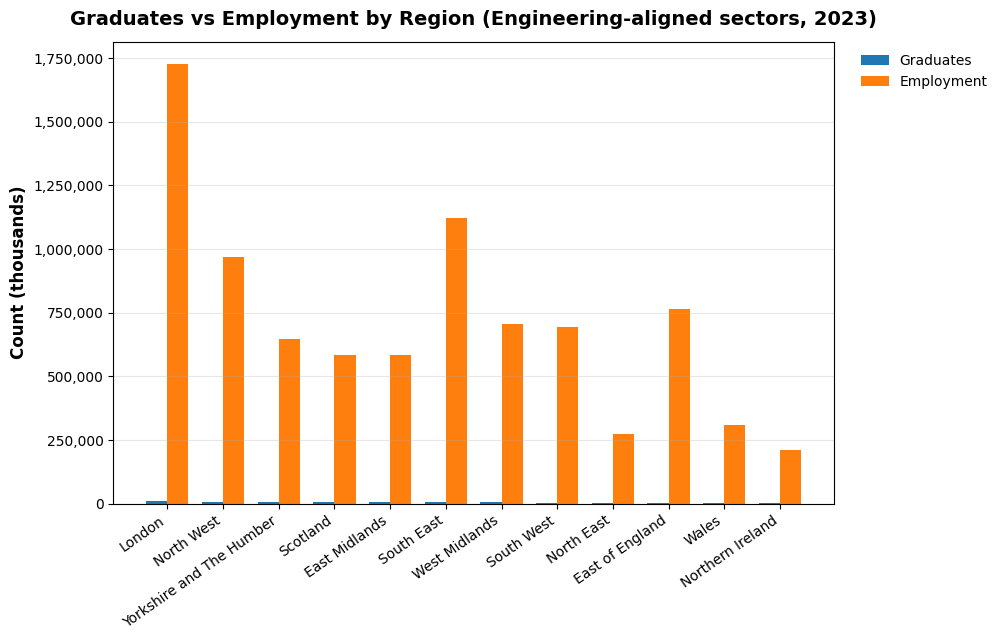

In [40]:
# df_grads: columns ["Region","Number"]
# df_emp: columns ["Region","Broad Industry Group","All_total_employment"]

aligned = prepare_regional_alignment_no_year(
    df_grads, df_emp,
    sectors=[
        "Manufacturing",
        "Construction",
        "Information & Communication",
        "Professional, Scientific & Technical",
        "Electricity, gas, steam & air conditioning supply",
        "Water supply, sewerage, waste & remediation activities",
    ],
)

_ = plot_grads_vs_employment_by_region(
    aligned,
    title="Graduates vs Employment by Region (Engineering-aligned sectors, 2023)",
    out_dir="chart-14",
    filename="chart14_grads_vs_employment_by_region",
    show=True,
    sort_by="Graduates",  # or "Employment"
)
